In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-10 16:52:11.891080: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-10 16:52:11.923542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-10 16:52:11.923894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-10 16:52:11.924077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-10 16:52:11.925459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-10 16:52:11.926784: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [4]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 224
# SIZE = 228          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
# batch_size = 64
batch_size = 15
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 179 images belonging to 1 classes.


In [6]:
validation_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [7]:
anomaly_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


In [8]:
test_set_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [9]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
15


2023-06-10 16:52:12.458678: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-10 16:52:12.463228: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-06-10 16:52:12.463539: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f817c001040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-10 16:52:12.463551: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-10 16:52:12.532610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-10 16:52:12.533004: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4244720 initialized for platform CUDA (this does not guarantee that XLA will

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


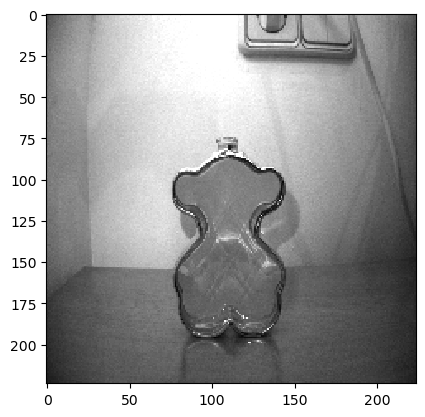

In [10]:
single_img = images_in_batch[0]
plt.imshow(single_img)

# Configuring the Autoencoder netwrok

In [11]:
latent_dim = 24  # Number of latent dimension parameters

input_img = Input(shape=(SIZE, SIZE, 3))
x = Conv2D(128, (3, 3), activation='relu', padding='same') (input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(49, activation='relu')(x)

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

(None, 7, 7, 1)
(None, 24)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None

In [12]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(14*14*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)
x = Reshape((14,14,4),input_shape=(784,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 784)               19600     
_________________________________________________________________
original_decoder (Dense)     (None, 784)               615440    
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 3)         111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 3)         84  

In [13]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mean_squared_error')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0   

These are the weights of a specific layer of the encoder model, before training are:

In [14]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  15
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[ 0.06901142, -0.03655398, -0.04543285, ..., -0.01330999,
          -0.05845601,  0.02424432],
         [ 0.01006145, -0.04351597,  0.03533997, ..., -0.01143959,
          -0.05150453, -0.01097959],
         [ 0.00067984, -0.0670474 ,  0.04670899, ..., -0.04317734,
          -0.02967387, -0.06577711]],

        [[ 0.06423564, -0.01281948,  0.02186076, ...,  0.03965915,
          -0.04654644, -0.02625135],
         [ 0.01458634, -0.02553102, -0.02019916, ..., -0.01834491,
          -0.07038596, -0.00244235],
         [ 0.01411951,  0.00974409, -0.01864441, ..., -0.02156108,
           0.04225875,  0.00388213]],

        [[-0.05801728, -0.05286673,  0.00558851, ...,  0.03087726,
           0.06404078,  0.06149139],
         [-0.04081088,  0.02757003,  0.00101133, ...,  0.00557492,
          -0.00842541, -0.04108029],
         [-0.03424295

These are the weights of a specific layer of the decoder model,before training are:

In [15]:
# layer_number = 1
# print("quantity of layers in the model: ", len(decoder.layers))
# print("The weigths in the", decoder.layers[layer_number].name, "is: ", decoder.layers[layer_number].weights)

These are the weights of a specific layer of the autoencoder model,before training are:

In [16]:
# layer_number = 1
# print("quantity of layers in the model: ", len(ae.layers))
# print("The weigths in the", ae.layers[layer_number].name, "is: ", ae.layers[layer_number].weights)

In [17]:
# # from tensorflow.keras.callbacks import EarlyStopping
# # # run the model
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=5, mode='auto')
# history = ae.fit(train_generator, epochs=200, validation_data=validation_generator, verbose=1, shuffle = True)

In [18]:

# # Get the training and validation loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Plot the training and validation loss
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [19]:
model_version = 'ResemblingGoodAutoModel3'
print(model_version)

ResemblingGoodAutoModel3


In [20]:
# ae.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

In [21]:
print(type(ae))

<class 'tensorflow.python.keras.engine.training.Model'>


Loading the model that was previously saved


In [22]:
model = keras.models.load_model('../models/ResemblingGoodAutoModel3')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


## See the weights after the model loading

These are the weights of a specific layer of the encoder model, AFTER training:

In [23]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  15
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[ 0.06901142, -0.03655398, -0.04543285, ..., -0.01330999,
          -0.05845601,  0.02424432],
         [ 0.01006145, -0.04351597,  0.03533997, ..., -0.01143959,
          -0.05150453, -0.01097959],
         [ 0.00067984, -0.0670474 ,  0.04670899, ..., -0.04317734,
          -0.02967387, -0.06577711]],

        [[ 0.06423564, -0.01281948,  0.02186076, ...,  0.03965915,
          -0.04654644, -0.02625135],
         [ 0.01458634, -0.02553102, -0.02019916, ..., -0.01834491,
          -0.07038596, -0.00244235],
         [ 0.01411951,  0.00974409, -0.01864441, ..., -0.02156108,
           0.04225875,  0.00388213]],

        [[-0.05801728, -0.05286673,  0.00558851, ...,  0.03087726,
           0.06404078,  0.06149139],
         [-0.04081088,  0.02757003,  0.00101133, ...,  0.00557492,
          -0.00842541, -0.04108029],
         [-0.03424295

These are the weights of a specific layer of the Autoencoder model, AFTER training:

In [24]:
layer_number = 1
print("quantity of layers in the model: ", len(model.layers))
print("The weigths in the", model.layers[layer_number].name, "is: ", model.layers[layer_number].weights)

quantity of layers in the model:  16
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[-7.13293394e-03,  8.24042559e-02,  3.44389230e-02, ...,
          -7.36624226e-02, -2.44387183e-02,  5.29763252e-02],
         [-2.88722049e-02,  4.07046154e-02,  4.88731936e-02, ...,
          -3.91994156e-02,  5.30144311e-02,  1.14909723e-01],
         [ 3.28725725e-02,  2.81612333e-02, -1.73458946e-03, ...,
           2.94835474e-02, -5.42051904e-02,  1.39015242e-01]],

        [[ 9.32509452e-03, -7.70046099e-05, -4.32104655e-02, ...,
          -5.05559109e-02, -2.28999127e-02, -6.65137023e-02],
         [ 5.03277741e-02,  1.43351909e-02,  6.64972216e-02, ...,
          -1.18463971e-02,  6.59165233e-02, -9.59516466e-02],
         [ 6.68021291e-02, -4.90201786e-02, -9.02428478e-03, ...,
           2.56796069e-02, -1.26518635e-02, -4.64316867e-02]],

        [[ 4.60277572e-02, -4.33564670e-02,  6.02726676e-02, ...,
          -7.099418

Indeed the weights of the "Autoencoder" model have been updated but the ones from the "Encoder" have not. This is expected, since the model that was trained was actually the "Autoencoder" mdoel.

## Perform an Autoencoder reconstruction in one image

Get all batches generated by the datagen and pick a batch for prediction

In [25]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(train_generator):        #I think this should be the correct while clause
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  12


In [26]:
print(len(data_batch))

12


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [27]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(15, 224, 224, 3)


2023-06-10 16:52:16.170844: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-10 16:52:16.429173: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


(15, 224, 224, 3)


The above is 15 length because it corresponds to the 15 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

In [28]:
single_img = data_batch[0][0]

In [29]:
print(single_img.shape)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


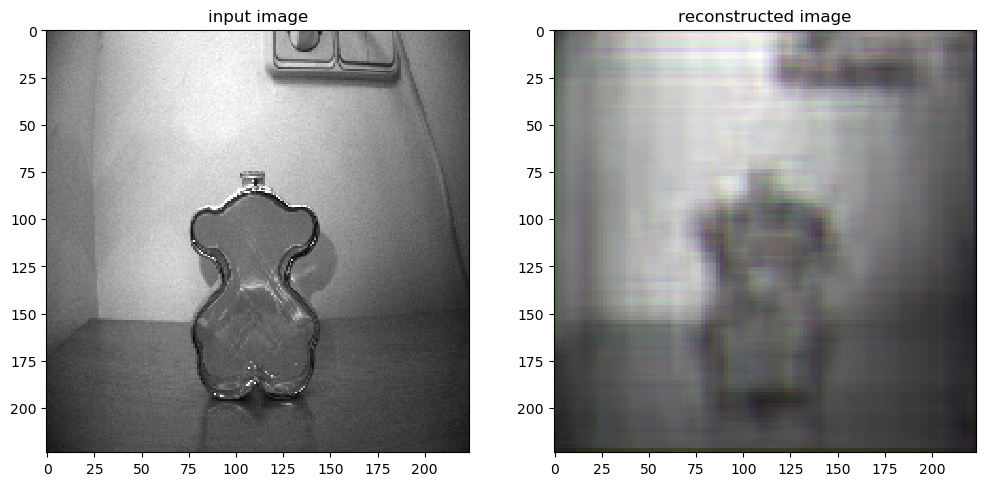

In [30]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0]-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

# Quantifying the reconstruction error using "evaluate_generator()" function

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [31]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Recon. error for the validation (normal) data is:  0.0034240693785250187


This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [32]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

Recon. error for the anomaly data is:  0.0037127940449863672


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [33]:
training_error = model.evaluate_generator(train_generator)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

Recon. error for the training (non-anomaly) data is:  0.003352927742525935


See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

Also see tha the error from the anomaly images is smaller than the error of the training set, which consists of non-anomaly images. THis is not expected and means that this particular model is shit.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [34]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [35]:
total_rec_error = []
for i in range(len(train_generator)):        #I think this should be the correct while clause
    data = train_generator.next()
    total_rec_error.append(calc_recon_error(data[0]))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")

1/1 [==============================] - 0s 805us/step - loss: 0.0041
The list of rec. error contains  12 batches of rec. errors


In [37]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

179


In [38]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.003953405120019806
The standard deviation of the errors list is:  0.0005144655849014008
The min value of the errors list is:  0.0033661010675132275
The max value of the errors list is:  0.00713358074426651


Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [39]:
anomaly_batch = anomaly_generator.next()

In [40]:
total_rec_error_anomalies = []
for i in range(len(anomaly_generator)):        #I think this should be the correct while clause
    data = anomaly_generator.next()
    total_rec_error_anomalies.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_anomalies), "batches of rec. errors")

1/1 [==============================] - 0s 869us/step - loss: 0.0038
The list of rec. error for anomalies contains  1 batches of rec. errors


In [41]:
total_rec_error_anomalies = [item for sublist in total_rec_error_anomalies for item in sublist]
print(len(total_rec_error_anomalies))

6


In [42]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.0045116598485037684
The standard deviation of the errors list is:  0.0012088108705086825
The min value of the errors list is:  0.0036004690919071436
The max value of the errors list is:  0.007110084407031536


Compute the average and std dev. of recon. error for the validation (non-anomalies) samples. 


In [43]:
total_rec_error_validation = []
for i in range(len(validation_generator)):        #I think this should be the correct while clause
    data = validation_generator.next()
    total_rec_error_validation.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_validation), "batches of rec. errors")

1/1 [==============================] - 0s 612us/step - loss: 0.0046
The list of rec. error for anomalies contains  2 batches of rec. errors


In [44]:
total_rec_error_validation = [item for sublist in total_rec_error_validation for item in sublist]
print(len(total_rec_error_validation))

30


In [45]:
val_average_recon_error = np.mean(np.array(total_rec_error_validation))  
val_stdev_recon_error = np.std(np.array(total_rec_error_validation)) 
min_prob = np.min(total_rec_error_validation)
max_prob = np.max(total_rec_error_validation)
print("THIS IS FOR THE VALIDATION IMAGES\n")
print("The average of the errors list is: ", val_average_recon_error)
print("The standard deviation of the errors list is: ", val_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE VALIDATION IMAGES

The average of the errors list is:  0.004568276694044471
The standard deviation of the errors list is:  0.00032553381149278505
The min value of the errors list is:  0.0040300143882632256
The max value of the errors list is:  0.00541169848293066


Below, we can see the plot of the reconstruction error values, of the non-anomaly list (blue) and the anomaly list (red).

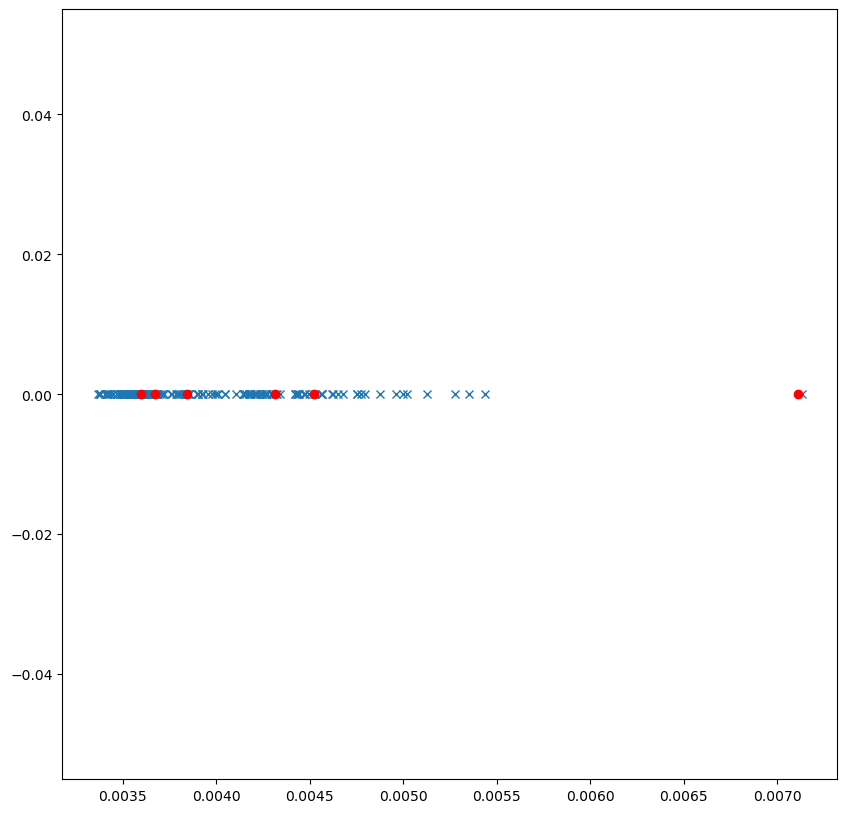

In [46]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.plot(total_rec_error_anomalies, np.zeros_like(total_rec_error_anomalies) + val, 'ro')
plt.show()

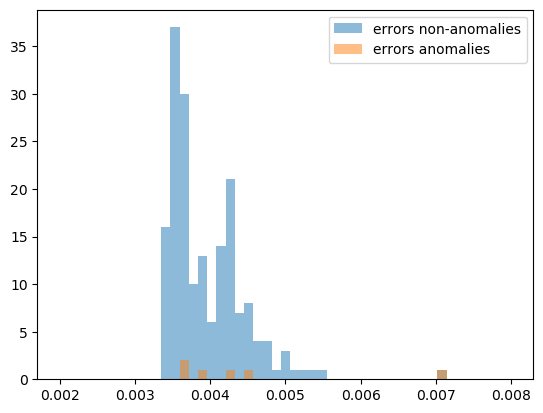

In [47]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0.002, 0.008, 50)

pyplot.hist(total_rec_error_list, bins, alpha=0.5, label='errors non-anomalies')
pyplot.hist(total_rec_error_anomalies, bins, alpha=0.5, label='errors anomalies')
pyplot.legend(loc='upper right')
pyplot.show()

## Checking the latent space

Let's update the weights of the encoder model.

In [48]:
# Copy the layer weights from the base model to the target model
for i, target_layer in enumerate(encoder.layers):
    base_layer = model.layers[i]
    target_layer.set_weights(base_layer.get_weights())

# Verify if the weights are successfully copied
for base_layer, target_layer in zip(model.layers[:len(encoder.layers)], encoder.layers):
    base_weights = base_layer.get_weights()
    target_weights = target_layer.get_weights()
    for base_weight, target_weight in zip(base_weights, target_weights):
        if (base_weight == target_weight).all():
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


In [49]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(train_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [50]:
print(encoded_images.shape)

(179, 24)


See that it is 179 length because it corresponds to all the images that belong to the training dataset. The second length corresponds to the output shape of the model as specified in its structure at the beginning.

In [51]:
type(encoded_images)

numpy.ndarray

In [52]:
encoder_output_shape = encoder.output_shape 
print(encoder_output_shape)

(None, 24)


Now, let's fit KDE to the image latent data

In [53]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images)

The above function fits a kernel density estimation to the data that is provided, that is, the "encoded_images" variable. It does so using a Guassian kernel of bandwidth 0.2.

The badnwidth parameter affects on how the selected kernel will fit each sample of the given data. For example for the case in which the kernel is a Gaussian distribution, the bandwidth parameter would affect in how thin or wide is the Gaussian distribution.

At this point in the variable "kde" we have some numbers that are the result of fitting Gaussian functions to the given data points in the variable "encoded_images". We will use the "kde" variable later for scoring with it, some given data points; the scoring will be given depending on how similar are the given data points to the ones that it had estimated.

Here below, it is shown the kde values corresponding to each encoded sample. THese are supposed to be very close to each other in value.

In [54]:
density_vals = kde.score_samples(encoded_images)
print(density_vals)

[11.60238689 12.33289009 12.04228107 12.94607689 14.17843702 13.46331629
 13.88335783 13.83728385 13.90164876 13.75317095 14.28337833 14.26173695
 12.33547735 12.34712946 12.51740292 13.80793885 14.31379002 13.52485563
 13.94628337 11.84990414 12.6896346  12.75462517 13.1326901  13.2183233
 13.65671652 11.74566004 12.62805096 12.40995889 12.73241596 13.02471104
 12.92984219 13.82003509 12.92594796 12.9769961  12.78832175 13.21394695
 13.30810109 13.13693866 12.92966098 12.65524139 12.15015619 13.11608193
 14.10076031 13.88934129 13.80084309 13.07582471 13.16807053 13.29673207
 13.33144203 13.32999167 13.21114044 13.7395575  13.73172859 13.7445209
 13.82785917 13.48677885 14.11653502 14.11801484 14.14959126 14.12146459
 12.78935442 13.30031183 12.84548655 14.04684576 14.37820038 14.3942462
 14.36347182 14.19296776 14.11795418 14.19982742 13.8319067  13.50505548
 13.25617236 14.21884153 13.48322778 13.88420589 13.8966712  13.85811399
 13.78692173 13.84007039 12.78935442 13.30031183 12.84

From here, the mean and standard deviation of these values are computed

In [55]:
average_density = np.mean(density_vals)
stdev_density = np.std(density_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  13.47878319093863
The stdev_density of the density values is:  0.6335057744637637


based on the above data create a function that outputs a probability of a KDE value to be considered an anomaly or non-anomaly image

In [56]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [57]:
# def map_kde2prob_list(input_list):
#     threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
#     std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
#     prob_score_list = []
#     prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
#     for i in range (len(input_list)):
#         aux_score = input_list[i] - threshold
#         if aux_score>=0:
#             additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
#             prob_score_tot = prob_score+additional
#         else:
#             additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
#             prob_score_tot = prob_score-additional
#         if prob_score_tot > 100:
#             prob_score_tot = 100
#         if prob_score_tot < 0:
#             prob_score_tot = 0
#         prob_score_list.append(prob_score_tot)
#     return prob_score_list

In [58]:
# def map_kde2prob(value):
#     threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
#     std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
#     prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
#     aux_score = value - threshold
#     print("value is: ", value)
#     print("aux_score is: ", aux_score)
        
#     if aux_score>=0:
#         additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
#         print("additional is: ", additional)
#         prob_score_tot = prob_score+additional
#         print("prob_score_tot is: ", prob_score_tot)
        
#     else:
#         additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
#         prob_score_tot = prob_score-additional
#     if prob_score_tot > 100:
#         prob_score_tot = 100
#     if prob_score_tot < 0:
#         prob_score_tot = 0    
#     return prob_score_tot

In [59]:
def map_kde2prob_list(input_list):
    threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
    prob_score_list =[]
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100     
        prob_score_list.append(prob_score)
    return prob_score_list

In [60]:
def map_kde2prob(value):
    threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
    
    aux_score = value - threshold
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
            prob_score = 0
    if prob_score>100:
        prob_score = 100 
    return prob_score

In [61]:
def computePred(kde_value):
    pred = 0
    prob_anomaly = map_kde2prob(kde_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [62]:
print(map_kde2prob_list([average_density - 1*stdev_density]))

[50.000000000000014]


In [63]:
#Get encoded output of input images = Latent space
encoded_images_test_set = encoder.predict_generator(test_set_generator)

In [64]:
print(encoded_images_test_set.shape)

(30, 24)


In [65]:
density_vals_test = kde.score_samples(encoded_images_test_set)
print(density_vals_test)

[12.82740601 13.10425084 13.32903949 13.41552596 13.42324581 13.47652501
 12.82736743 12.80796898 12.36919885 12.57485747 12.55457261 12.59323967
 12.54387059 12.64278394 12.91955027 12.61598688  9.81014647 10.88603516
 12.11466402 12.03678128 12.04376504 12.18148313 12.10051742 12.23779127
 12.29340996 11.75665576 12.00574532 11.24410198 11.85772346 11.68392146]


In [66]:
average_density + stdev_density

14.112288965402394

In [67]:
average_density - stdev_density

12.845277416474866

In [68]:
prob_test = map_kde2prob_list(density_vals_test)
print(prob_test)

[51.4105167062246, 29.560295178692126, 11.81865291438597, 4.992632510555373, 4.383336629405955, 0.1782286339017885, 51.41356134496441, 52.94460082863467, 87.57491917383031, 71.3431319636687, 72.9441320376067, 69.89230041235186, 73.78879891058865, 65.98197527989342, 44.137949612831356, 68.09695715025298, 100, 100, 100, 100, 100, 100, 100, 97.94637800343725, 93.5566242830613, 100, 100, 100, 100, 100]


See the final predictions based on the KDE average values that was computed before.

In [69]:
ground_truth = []
for i in range(len(test_set_generator)):        #I think this should be the correct while clause
    _, labels = test_set_generator.next()
    ground_truth.append(labels)
    
print("The list of rec. error for anomalies contains ", len(ground_truth), "batches of rec. errors")

The list of rec. error for anomalies contains  2 batches of rec. errors


In [70]:
ground_truth = [item for sublist in ground_truth for item in sublist]
ground_truth = [int(x) for x in ground_truth]


In [71]:
pred_list =[]
for i in range(len(prob_test)):
    
    if(prob_test[i]>50):
        pred = 1
    else:
        pred = 0
    pred_list.append(pred)
print(ground_truth)
print(pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [72]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(ground_truth, prob_test))

AUC =  0.86


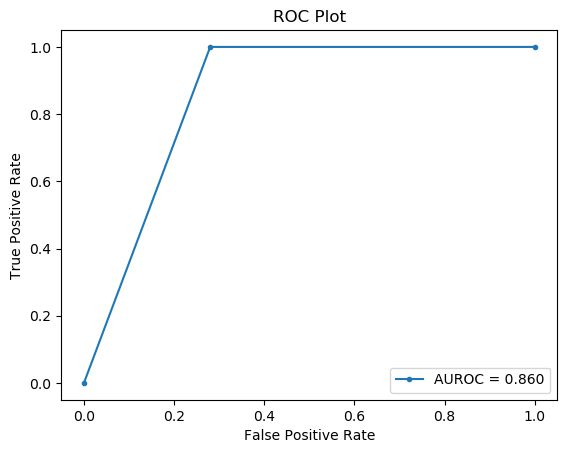

In [73]:
fpr, tpr, thresholds = metrics.roc_curve(ground_truth, prob_test)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(ground_truth, prob_test))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [74]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.28 1.  ]
The tpr is:  [0. 1. 1.]
The thresholds are:  [101.         100.           0.17822863]


## Trehshold based on Gaussian distribution of the non-anomaly images

In [75]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

See below test, that shows if a reconstruction error is equal to the mean of the reconstruction error plus its standard deviation has 50% chance of being predicted as anomaly image.

In [76]:
print(map_error2prob(na_average_recon_error - na_stdev_recon_error))

49.999999999999986


In [77]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

In [78]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [79]:
y_pred_final = []
y_true_final = []
y_prob_final = []
for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images, labels = next(test_set_generator)
    y_pred = []
    y_true = []
    y_prob = []
    for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        probability = map_error2prob(reconstruction_error)
        prediction = computePred(reconstruction_error)   
        y_pred.append(prediction) # Save Prediction
        y_true.append(labels[im]) # Save Truth  
        y_prob.append(probability) # Save probability  
    y_pred_final.append(y_pred)  
    y_true_final.append(y_true)  
    y_prob_final.append(y_prob)  
print(y_true_final)
print(y_pred_final)
print(y_prob_final)
 

1/1 [==============================] - 0s 695us/step - loss: 0.0068
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0], [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
[[73.84153934142958, 64.35331615088906, 55.24719609456425, 62.44651153713659, 56.943104035872636, 51.25894088874138, 23.329613964832433, 18.74577931494, 61.053824133462406, 30.00834047540385, 50.8839883283982, 38.25163970337104, 54.95958915177839, 39.789737194719656, 22.270831206929152], [67.52880454546231, 62.18709957867104, 28.3525753127345, 7.445519242856853, 91.84098199617529, 95.2351059754218, 100, 100, 100, 82.51876073579031, 100, 100, 100, 100, 100]]


In [80]:
y_true_final = [item for sublist in y_true_final for item in sublist]
y_true_final = [int(i) for i in y_true_final]
y_pred_final = [item for sublist in y_pred_final for item in sublist]
y_prob_final = [item for sublist in y_prob_final for item in sublist]
print(y_true_final)
print(y_pred_final)
print(y_prob_final)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[73.84153934142958, 64.35331615088906, 55.24719609456425, 62.44651153713659, 56.943104035872636, 51.25894088874138, 23.329613964832433, 18.74577931494, 61.053824133462406, 30.00834047540385, 50.8839883283982, 38.25163970337104, 54.95958915177839, 39.789737194719656, 22.270831206929152, 67.52880454546231, 62.18709957867104, 28.3525753127345, 7.445519242856853, 91.84098199617529, 95.2351059754218, 100, 100, 100, 82.51876073579031, 100, 100, 100, 100, 100]


Above we see the predictions based on a threshold of 50%. See that the results are not that good. There is a high rate of false positives. 

AUC =  0.94


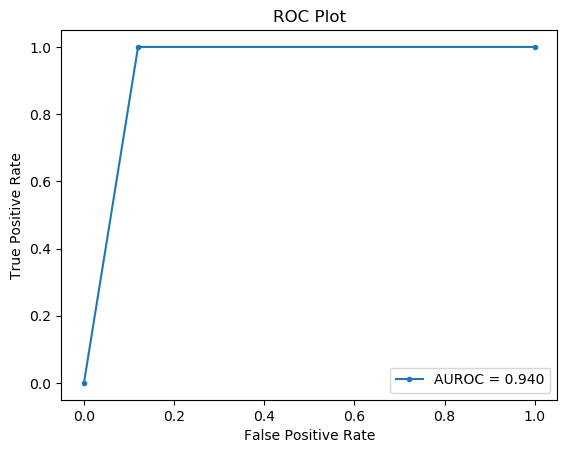

The fpr is:  [0.   0.12 1.  ]
The tpr is:  [0. 1. 1.]
The thresholds are:  [101.         100.           7.44551924]


In [81]:
print('AUC = ', metrics.roc_auc_score(y_true_final, y_prob_final))
fpr, tpr, thresholds = metrics.roc_curve(y_true_final, y_prob_final)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true_final, y_prob_final))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

Here it is seen that if the threshold were to change from being 50% to (100-7.4455)%, then the FPR would get better; it wouldn't be so high, in fact, it would be of 0.12. Let's asses this statement.

In [82]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [83]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [86]:
conf_matrix = confusion_matrix(y_true_final, pred_label_onProb(y_prob_final, (100-7.4455)))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = 100-7.4455")

[[21  4]
 [ 0  5]]
The FPR values are:  0.16
The TPR values are:  1.0
Using the threshold = 100-7.4455


The FPR is not exactly 0.12 but close to it. It might be due to decimals. 

Updated NOTE: IT seems like in the metrics.roc_auc_score(y_true_final, y_prob_final) function, the threshold values that are displayed, are ALWYAS to be subtracted from 100, but subrtacted the indicated quantity directly. IN this way, we can obtain the closer result to FPR = 0.12.